##Bring in libraries and dataframes and set indexes

In [5]:
import datetime
import pandas as pd
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
import ETFunctions
%matplotlib inline
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [6]:
AllTDRData = pd.read_pickle('.\DataFrames\AllSoilVWC.pkl')
NeutronProbeData = pd.read_excel('.\RawDatafiles\NeutronProbe.xlsx', sheetname='WideData', index_col = 0)

In [7]:
#Set up column indexs in neutron probe data
NeutronProbeDataTransposed = NeutronProbeData.transpose()
NeutronProbeDataTransposed.set_index(['Depth','Irrigation','Cultivar','Block','Plot'], inplace = True)
NPData = NeutronProbeDataTransposed.transpose() 
NPData.fillna('backfill', inplace=True)

#Extract TDR data at the times neutron probe data was measured
Dates = NPData.index.tolist()
TDRData = AllTDRData.ix[Dates,:] 

#Calculate mean VWC in top 30cm from CS650's to compare with trace TDR values (in neutro probe dataset)
TDRReducedIndex = TDRData.transpose() #flip data frame so we can work with indexs
TDRReducedIndex.index = TDRReducedIndex.index.droplevel(level = ['Plot','Sensor', 'MUX', 'Port','Units','Summary','Treatment','Rewet']) #drop index values that will get in the way
TDRT = ((TDRReducedIndex.ix['D1B',:] + TDRReducedIndex.ix['D1I',:])/2 + TDRReducedIndex.ix['D2',:])/2 #calculate VWC in top 30 cm
TDRT.ix[:,'Depth'] = 'D1'  # insert depth label into dataframe
TDRT.set_index(['Depth'], inplace = True, append = True)  #add depth into the multiindex so we can join this back into the TDRData dataframe
TDR1 = TDRT.transpose()  # Transpose it back for joining
TDR1.columns = TDR1.columns.swaplevel('Depth','Block')         #Get multiindex lables into the same order as TDRData for joining
TDR1.columns = TDR1.columns.swaplevel('Depth','Irrigation')   #Get multiindex lables into the same order as TDRData for joining
TDR1.columns = TDR1.columns.swaplevel('Depth','Cultivar')     #Get multiindex lables into the same order as TDRData for joining
TDROthers = TDRReducedIndex.transpose()
#TDROthers.columns = TDROthers.columns.swaplevel('Plot','Block')
TDROthers.drop(labels = ['D1B','D1I','D2'], axis = 1, level = 'Depth', inplace=True) #Drop the components of the 30cm VWC calculation
TDRAgregated = pd.concat([TDROthers, TDR1], axis = 1)  # join data back in
#TDRAgregated = TDRAgregated.sortlevel(axis =1, level = 'Block') # get into same order as NP data
NPData.columns = NPData.columns.droplevel('Block')             # remove block from NP data so the two frames have the same index
NPData.columns = NPData.columns.swaplevel('Cultivar','Irrigation')
NPData.where(NPData>0, inplace = True)                         # replace zero values with Nan because they are missing
NPData = NPData.divide(100)

##Calculate profile water contents and graph

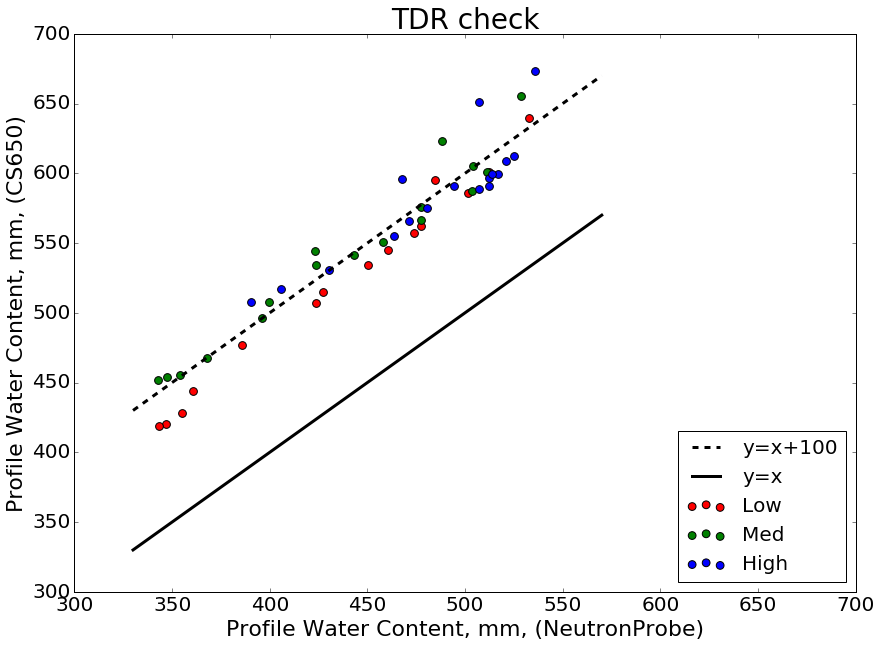

In [8]:
#calculate profile water contents from TDR
TDRMeans = TDRAgregated.groupby(level =['Irrigation'], axis=1).mean() 
TDRprofile = TDRMeans.multiply(1800)

#calculate profile water contest from Neutron probe
NPMeans = NPData.groupby(level=['Irrigation'],axis=1).mean()
NPprofile = NPMeans.multiply(1800)

#Draw a graph
plt.figure(figsize=(14, 10));
plt.title('TDR check', fontsize=28);
plt.scatter(NPprofile.Low, TDRprofile.Low, c='r', s=60, label='Low' );
plt.scatter(NPprofile.Mid, TDRprofile.Mid, c='g', s=60, label='Med');
plt.scatter(NPprofile.High, TDRprofile.High, c='b', s=60, label='High');
plt.plot([330,570], [430,670], 'k--', linewidth = 3, label = 'y=x+100')
plt.plot([330,570], [330,570], 'k-', linewidth = 3, label = 'y=x')
plt.ylim(300,700);
plt.xlim(300,700);
plt.legend(loc=4, fontsize=20)
plt.xlabel('Profile Water Content, mm, (NeutronProbe)', fontsize=22);
plt.ylabel('Profile Water Content, mm, (CS650)', fontsize=22);
plt.tick_params(labelsize=20)

##Calculate means at different depth and graph

In [9]:
TDRLayerMeans = TDRAgregated.groupby(level =['Irrigation', 'Depth'], axis=1).mean() 

NPLayerMeans = NPData.groupby(level=['Irrigation', 'Depth'],axis=1).mean()

#Set the DateTime data type for index
NPLayerMeans.index = NPLayerMeans.index.to_datetime()  ## for some reason the concat function changes the data type on the date indes so need to change it back
NPLayerMeans.index

DatetimeIndex(['2014-11-10 09:00:00', '2014-11-18 09:00:00',
               '2014-11-26 09:00:00', '2014-12-02 09:00:00',
               '2014-12-09 09:00:00', '2014-12-16 09:00:00',
               '2014-12-23 09:00:00', '2014-12-30 09:00:00',
               '2015-01-06 09:00:00', '2015-01-13 09:00:00',
               '2015-01-20 09:00:00', '2015-01-27 09:00:00',
               '2015-02-03 09:00:00', '2015-02-10 09:00:00',
               '2015-02-17 09:00:00', '2015-02-24 09:00:00',
               '2015-03-03 09:00:00'],
              dtype='datetime64[ns]', freq=None)

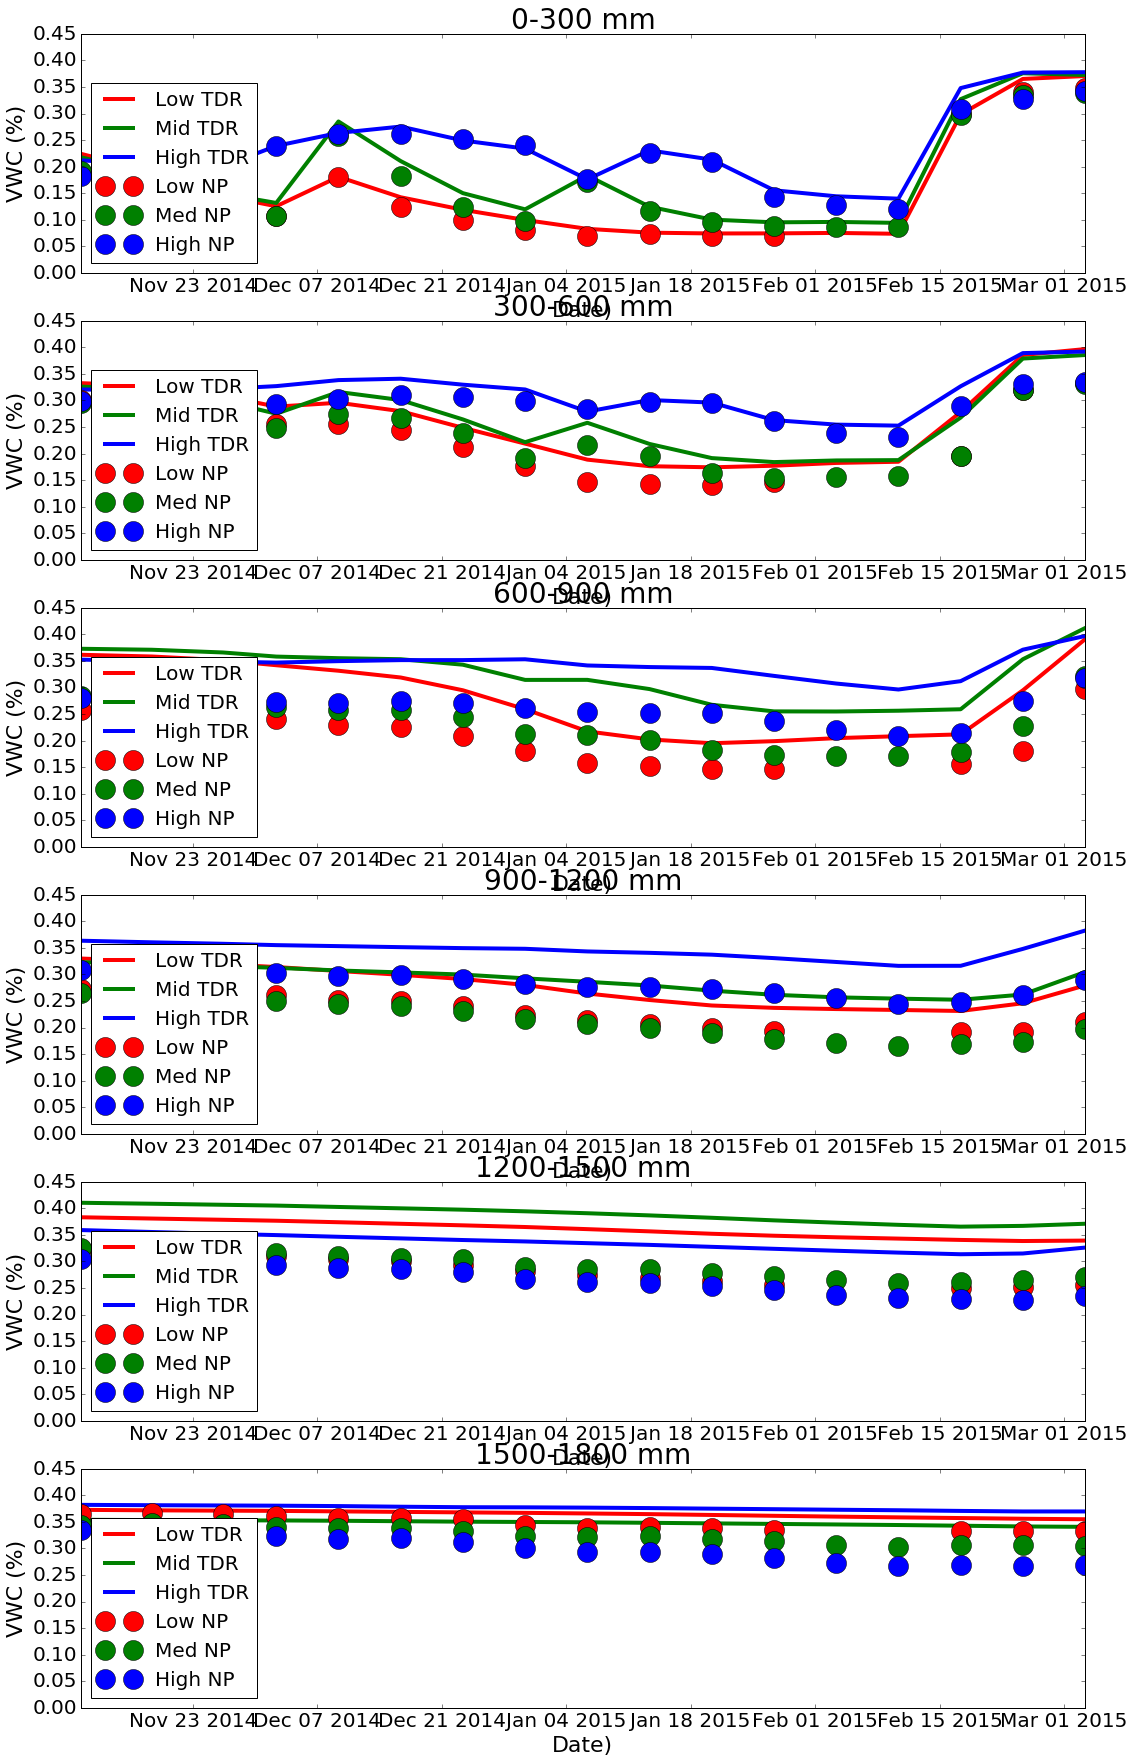

In [18]:
Fig = plt.figure(figsize=(18, 30))

def MakePlot(Position, Depth, DepthLabel):
        Fig.add_subplot(6,1,Position, color_cycle=['r','g','b','r','g','b'])
        plt.title(DepthLabel, fontsize=28)
        plt.plot(TDRLayerMeans.index, TDRLayerMeans.Low[Depth], '-', linewidth = 4, label='Low TDR');
        plt.plot(TDRLayerMeans.index, TDRLayerMeans.Mid[Depth], '-', linewidth = 4, label='Mid TDR') ;
        plt.plot(TDRLayerMeans.index, TDRLayerMeans.High[Depth], '-', linewidth = 4, label='High TDR');
        plt.plot(NPLayerMeans.index, NPLayerMeans.Low[Depth], 'o', markersize=20, label='Low NP');
        plt.plot(NPLayerMeans.index, NPLayerMeans.Mid[Depth], 'o', markersize=20, label='Med NP');
        plt.plot(NPLayerMeans.index, NPLayerMeans.High[Depth], 'o', markersize=20, label='High NP');
        plt.legend(loc=3, fontsize=20)
        plt.ylim(0,0.45);
        plt.xlabel('Date)', fontsize=22);
        plt.ylabel('VWC (%)', fontsize=22);
        plt.tick_params(labelsize=20)
        return;

MakePlot(1,'D1','0-300 mm')
MakePlot(2,'D3','300-600 mm')
MakePlot(3,'D4','600-900 mm')
MakePlot(4,'D5','900-1200 mm')
MakePlot(5,'D6','1200-1500 mm')
MakePlot(6,'D7','1500-1800 mm')

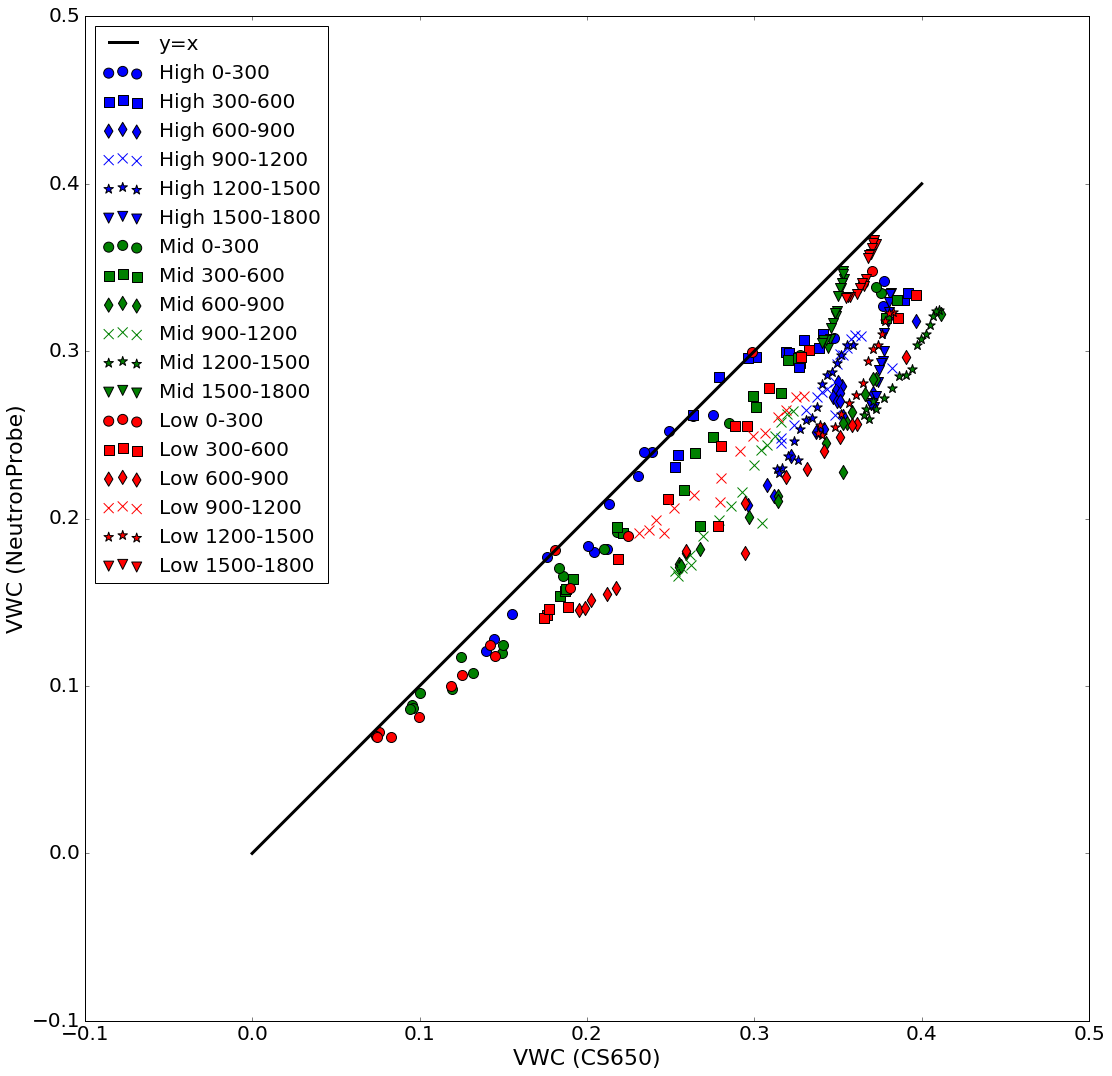

In [11]:
Fig = plt.figure(figsize=(18, 18))
plt.scatter(TDRLayerMeans.High.D1, NPLayerMeans.High.D1, c='b', s=100, label='High 0-300', marker='o')
plt.scatter(TDRLayerMeans.High.D3, NPLayerMeans.High.D3, c='b', s=100, label='High 300-600', marker='s')
plt.scatter(TDRLayerMeans.High.D4, NPLayerMeans.High.D4, c='b', s=100, label='High 600-900', marker='d')
plt.scatter(TDRLayerMeans.High.D5, NPLayerMeans.High.D5, c='b', s=100, label='High 900-1200', marker='x')
plt.scatter(TDRLayerMeans.High.D6, NPLayerMeans.High.D6, c='b', s=100, label='High 1200-1500', marker='*')
plt.scatter(TDRLayerMeans.High.D7, NPLayerMeans.High.D7, c='b', s=100, label='High 1500-1800', marker='v')
plt.scatter(TDRLayerMeans.Mid.D1, NPLayerMeans.Mid.D1, c='g', s=100, label='Mid 0-300', marker='o')
plt.scatter(TDRLayerMeans.Mid.D3, NPLayerMeans.Mid.D3, c='g', s=100, label='Mid 300-600', marker='s')
plt.scatter(TDRLayerMeans.Mid.D4, NPLayerMeans.Mid.D4, c='g', s=100, label='Mid 600-900', marker='d')
plt.scatter(TDRLayerMeans.Mid.D5, NPLayerMeans.Mid.D5, c='g', s=100, label='Mid 900-1200', marker='x')
plt.scatter(TDRLayerMeans.Mid.D6, NPLayerMeans.Mid.D6, c='g', s=100, label='Mid 1200-1500', marker='*')
plt.scatter(TDRLayerMeans.Mid.D7, NPLayerMeans.Mid.D7, c='g', s=100, label='Mid 1500-1800', marker='v')
plt.scatter(TDRLayerMeans.Low.D1, NPLayerMeans.Low.D1, c='r', s=100, label='Low 0-300', marker='o')
plt.scatter(TDRLayerMeans.Low.D3, NPLayerMeans.Low.D3, c='r', s=100, label='Low 300-600', marker='s')
plt.scatter(TDRLayerMeans.Low.D4, NPLayerMeans.Low.D4, c='r', s=100, label='Low 600-900', marker='d')
plt.scatter(TDRLayerMeans.Low.D5, NPLayerMeans.Low.D5, c='r', s=100, label='Low 900-1200', marker='x')
plt.scatter(TDRLayerMeans.Low.D6, NPLayerMeans.Low.D6, c='r', s=100, label='Low 1200-1500', marker='*')
plt.scatter(TDRLayerMeans.Low.D7, NPLayerMeans.Low.D7, c='r', s=100, label='Low 1500-1800', marker='v')
plt.plot([0,0.4], [0,0.4],'k-', linewidth = 3, label = 'y=x')
plt.legend(loc=2, fontsize=20)
plt.xlabel('VWC (CS650)', fontsize=22);
plt.ylabel('VWC (NeutronProbe)', fontsize=22);
plt.tick_params(labelsize=20)

C:\Users\cflhxb\AppData\Roaming\Python\Python27\site-packages\ipykernel\kernelbase.py:228: PerformanceWarning: indexing past lexsort depth may impact performance.
  handler(stream, idents, msg)


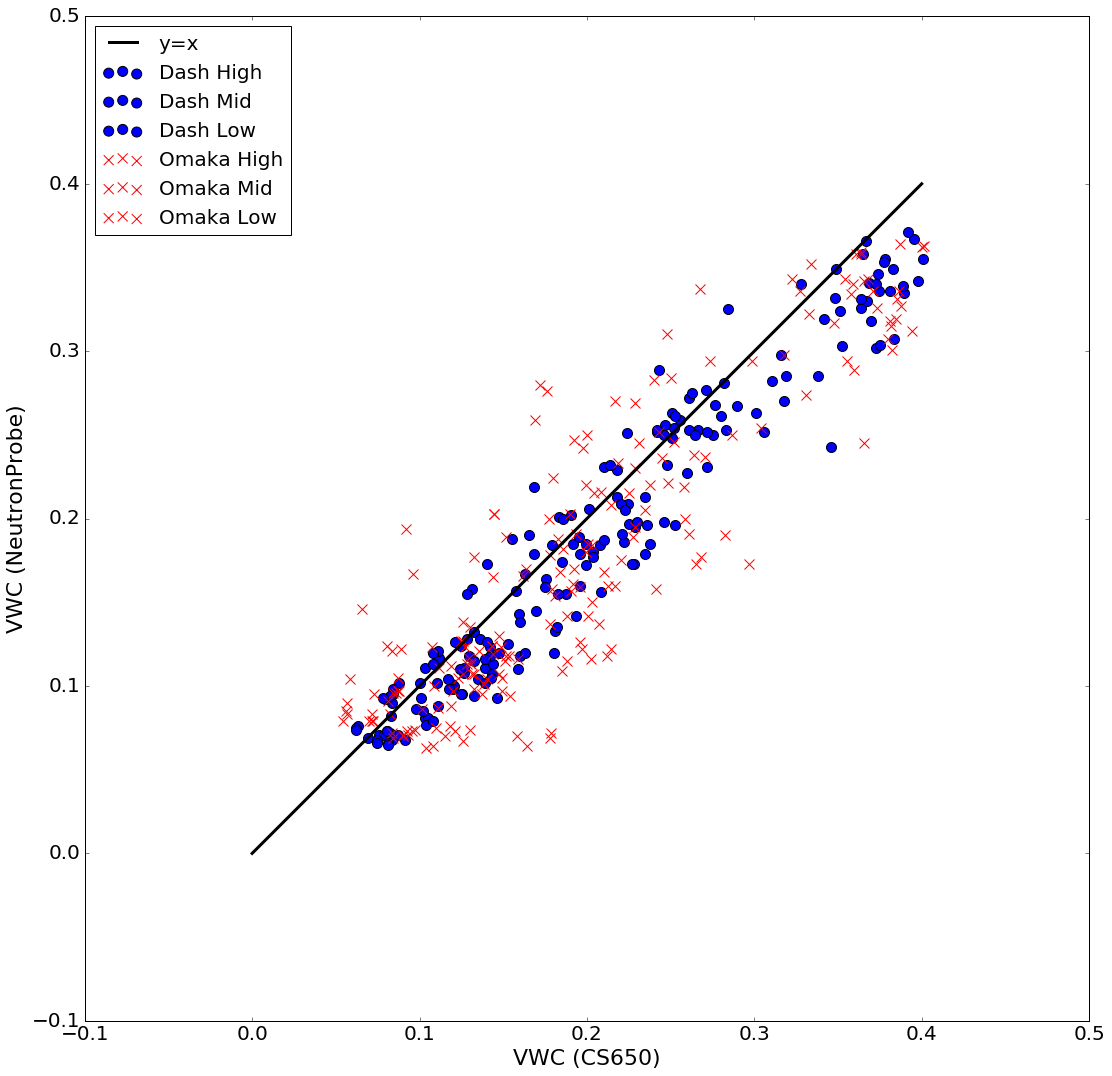

In [12]:
plt.rc('font', serif='shit') 
Depth = 'D1'
Fig = plt.figure(figsize=(18, 18))
plt.scatter(TDRAgregated[Depth,'Dash','High'], NPData[Depth,'Dash','High'], c='b', s=100, label='Dash High', marker='o')
plt.scatter(TDRAgregated[Depth,'Dash','Mid'], NPData[Depth,'Dash','Mid'], c='b', s=100, label='Dash Mid', marker='o')
plt.scatter(TDRAgregated[Depth,'Dash','Low'], NPData[Depth,'Dash','Low'], c='b', s=100, label='Dash Low', marker='o')
plt.scatter(TDRAgregated[Depth,'Omaka','High'], NPData[Depth,'Omaka','High'], c='r', s=100, label='Omaka High', marker='x')
plt.scatter(TDRAgregated[Depth,'Omaka','Mid'], NPData[Depth,'Omaka','Low'], c='r', s=100, label='Omaka Mid', marker='x')
plt.scatter(TDRAgregated[Depth,'Omaka','Low'], NPData[Depth,'Omaka','Mid'], c='r', s=100, label='Omaka Low', marker='x')
plt.plot([0,0.4], [0,0.4],'k-', linewidth = 3, label = 'y=x')
plt.legend(loc=2, fontsize=20)
plt.xlabel('VWC (CS650)', fontsize=22);
plt.ylabel('VWC (NeutronProbe)', fontsize=22);
plt.tick_params(labelsize=20)

C:\Users\cflhxb\AppData\Roaming\Python\Python27\site-packages\ipykernel\kernelbase.py:391: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)


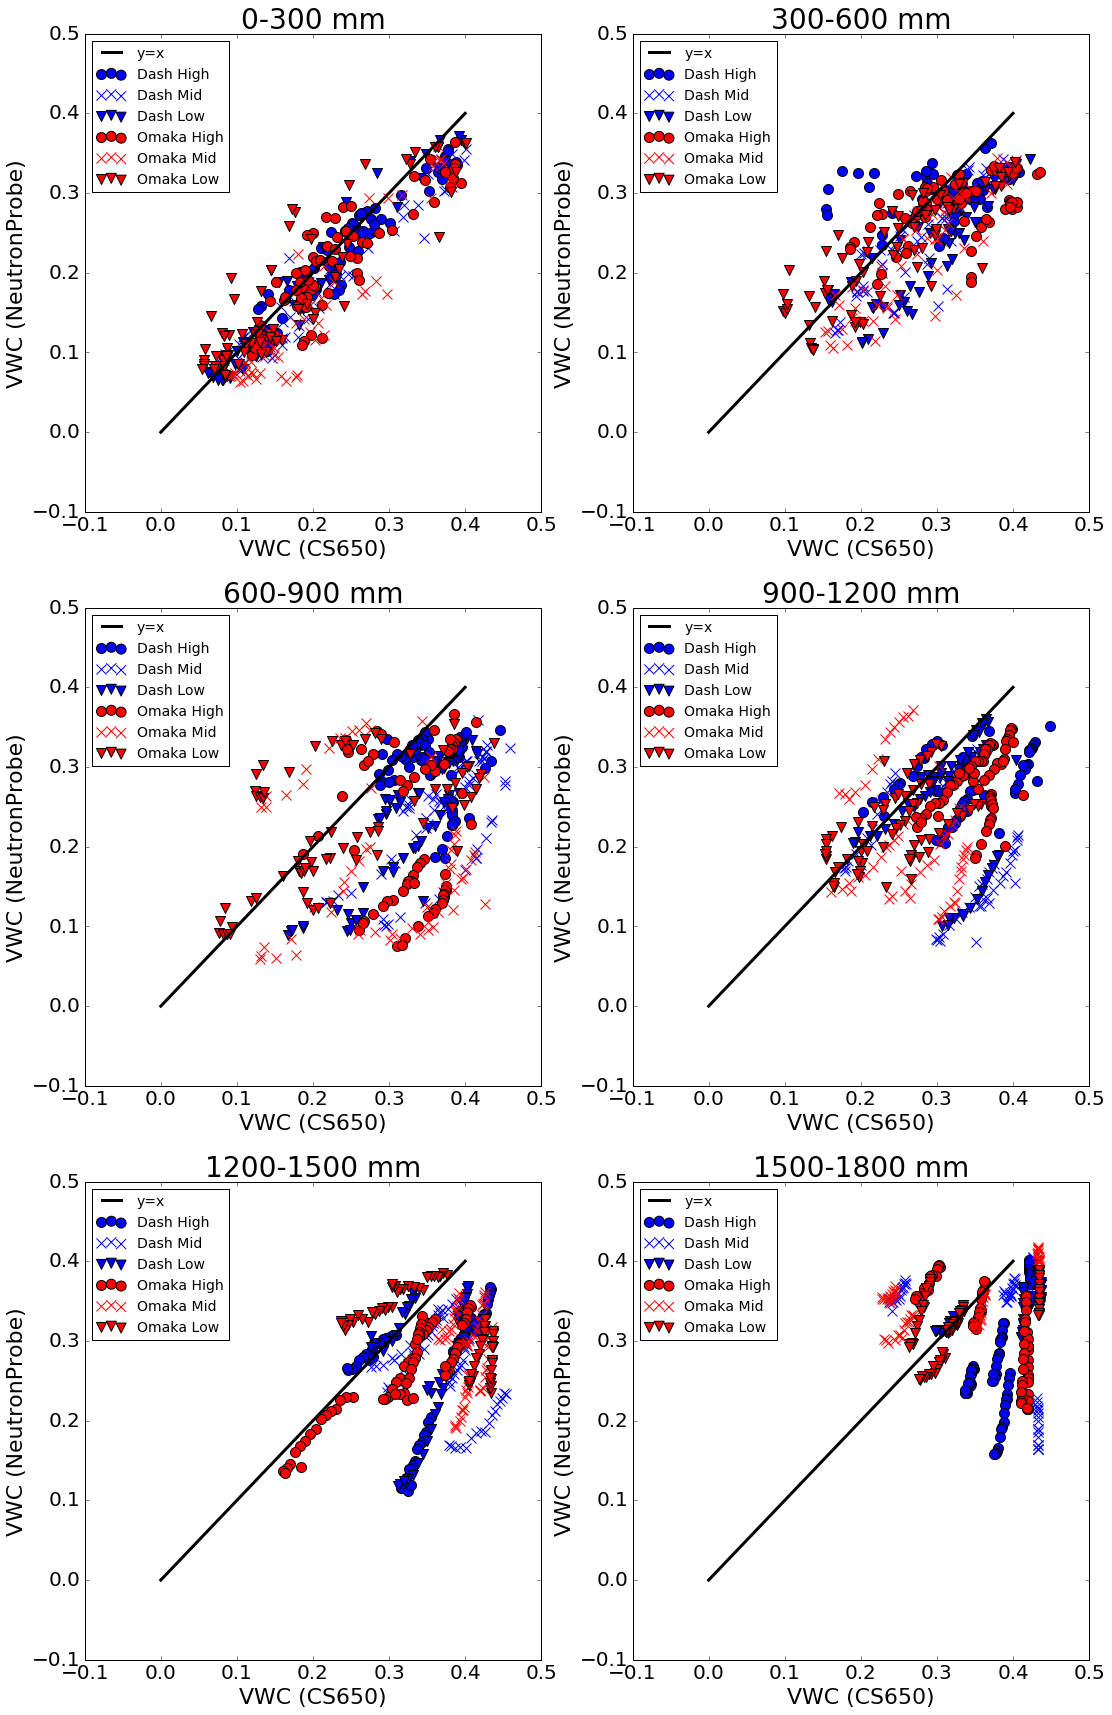

In [13]:
Fig = plt.figure(figsize=(18, 60))

def MakePlot(Position, Depth, DepthLabel):
    Fig.add_subplot(6,2,Position, color_cycle=['r','g','b','r','g','b'])
    plt.title(DepthLabel, fontsize=28)
    #Fig = plt.figure(figsize=(18, 18))
    plt.scatter(TDRAgregated[Depth,'Dash','High'], NPData[Depth,'Dash','High'], c='b', s=100, label='Dash High', marker='o')
    plt.scatter(TDRAgregated[Depth,'Dash','Mid'], NPData[Depth,'Dash','Mid'], c='b', s=100, label='Dash Mid', marker='x')
    plt.scatter(TDRAgregated[Depth,'Dash','Low'], NPData[Depth,'Dash','Low'], c='b', s=100, label='Dash Low', marker='v')
    plt.scatter(TDRAgregated[Depth,'Omaka','High'], NPData[Depth,'Omaka','High'], c='r', s=100, label='Omaka High', marker='o')
    plt.scatter(TDRAgregated[Depth,'Omaka','Mid'], NPData[Depth,'Omaka','Low'], c='r', s=100, label='Omaka Mid', marker='x')
    plt.scatter(TDRAgregated[Depth,'Omaka','Low'], NPData[Depth,'Omaka','Mid'], c='r', s=100, label='Omaka Low', marker='v')
    plt.plot([0,0.4], [0,0.4],'k-', linewidth = 3, label = 'y=x')
    plt.legend(loc=2, fontsize=14)
    plt.xlabel('VWC (CS650)', fontsize=22);
    plt.ylabel('VWC (NeutronProbe)', fontsize=22);
    plt.tick_params(labelsize=20)
    
MakePlot(1,'D1','0-300 mm')
MakePlot(2,'D3','300-600 mm')
MakePlot(3,'D4','600-900 mm')
MakePlot(4,'D5','900-1200 mm')
MakePlot(5,'D6','1200-1500 mm')
MakePlot(6,'D7','1500-1800 mm')

##Calculate slopes for each plot

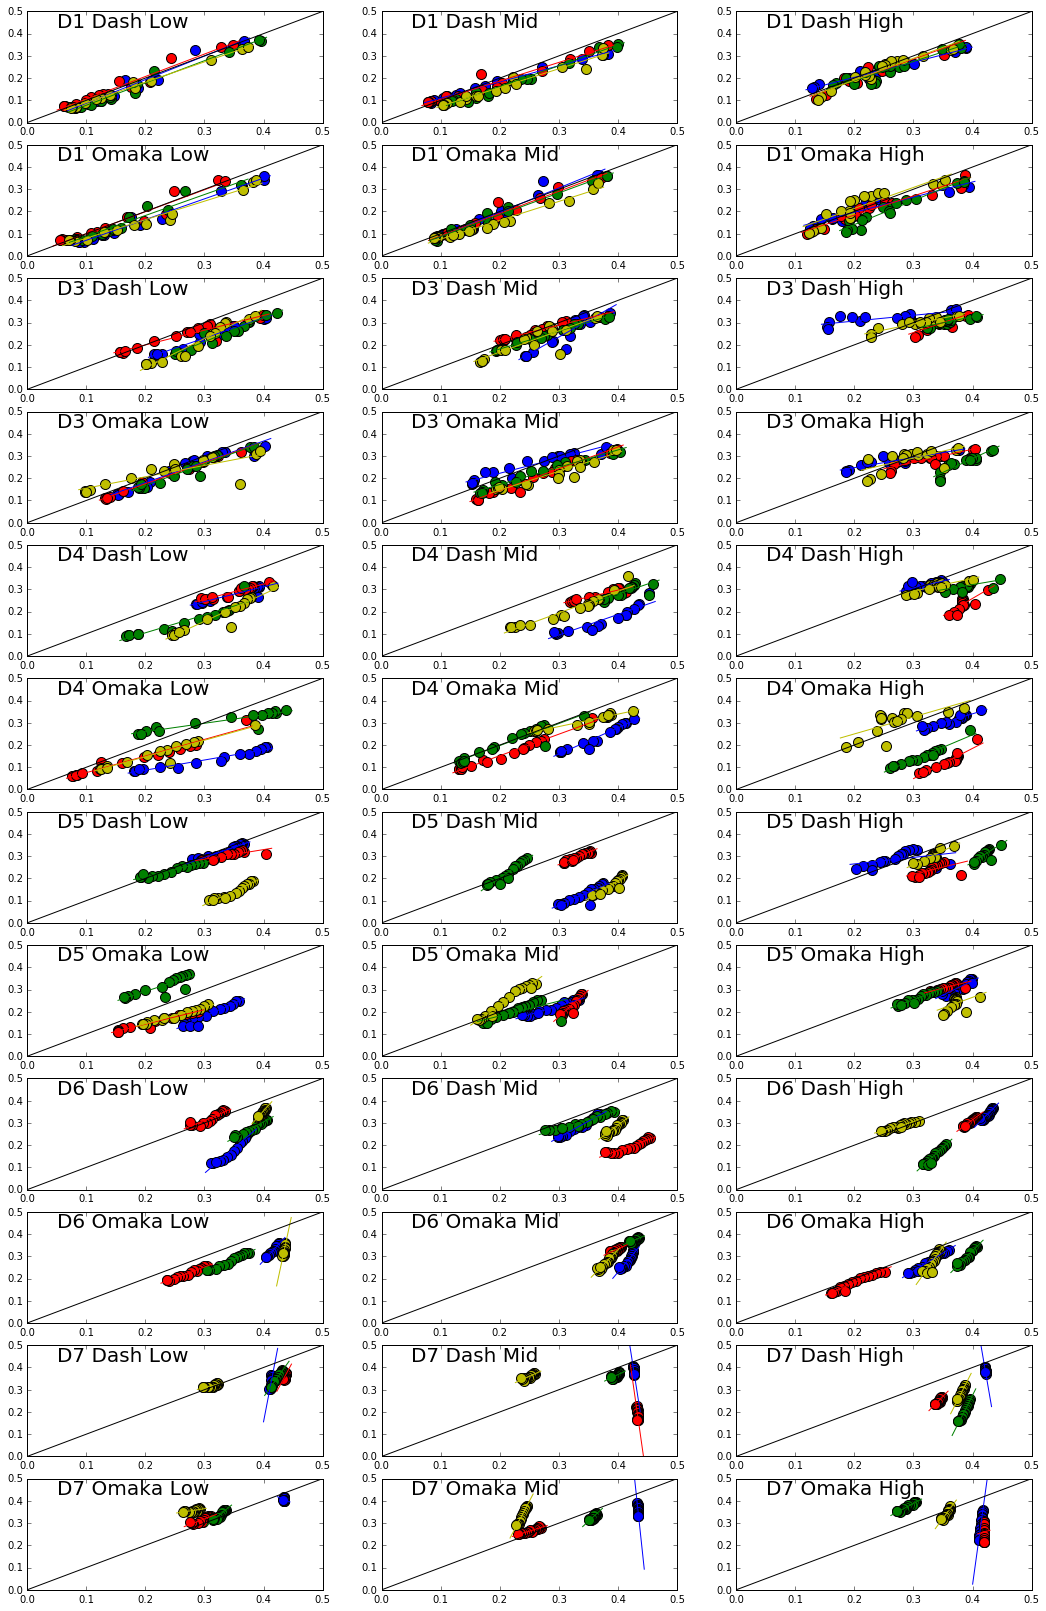

In [16]:
Depths = ['D1', 'D3', 'D4', 'D5', 'D6', 'D7']
Cultivars =['Dash', 'Omaka']
Irrigations = ['Low', 'Mid', 'High']
Reps = [0,1,2,3]

levels = [Depths, Cultivars ,Irrigations ,Reps]
DataIndex = pd.MultiIndex.from_product(levels, names=['Depth', 'Cultivar', 'Irrigation', 'Rep'])
CalibrationCoeffs = pd.DataFrame(index = DataIndex, columns = ['Slope','Intercept', 'R2'])

Calibrations = plt.figure(figsize = (18,100))

Colors = ['b','r','g','y']

Position = 1
for Depth in Depths:
    for Cultivar in Cultivars:
        for Irrigation in Irrigations:
            #Make graph for each treatment x Depth combination
            fig = Calibrations.add_subplot(42,3,Position)
            ColorPos = 0
            fig.text(0.05,0.43,Depth + ' ' +Cultivar + ' ' +Irrigation, fontsize = 20)
            plt.ylim(0,0.5)
            plt.xlim(0,0.5)
            for Rep in Reps:
                #Plot data for each rep
                plt.scatter(TDRAgregated[Depth,Cultivar,Irrigation].iloc[:,Rep],
                         NPData[Depth,Cultivar,Irrigation].iloc[:,Rep], 
                         c=Colors[ColorPos], s=100, label='Dash High', marker='o')
                #fit regression for each rep
                ModVWC = sm.regression.linear_model.OLS(NPData[Depth,Cultivar,Irrigation].iloc[:,Rep],  # Y variable
                                        sm.add_constant(TDRAgregated[Depth,Cultivar,Irrigation].iloc[:,Rep]), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
                RegVWC = ModVWC.fit();  # fit models parameters
                
                #Plot fitted regression for each rep
                lable = TDRAgregated[Depth,Cultivar,Irrigation].iloc[:,Rep].name
                X = [np.min(TDRAgregated[Depth,Cultivar,Irrigation].iloc[:,Rep])-0.01,
                    np.max(TDRAgregated[Depth,Cultivar,Irrigation].iloc[:,Rep])+0.01]
                Y = [RegVWC.params.const + X[0] * RegVWC.params.get_value(lable), 
                      RegVWC.params.const + X[1] * RegVWC.params.get_value(lable)]
                plt.plot(X,Y,c=Colors[ColorPos])
                
                #Assign calibration coefficients to data frame
                CalibrationCoeffs.ix[(Depth,Cultivar,Irrigation,Rep),'Slope'] = RegVWC.params.get_value(lable)
                CalibrationCoeffs.ix[(Depth,Cultivar,Irrigation,Rep),'Intercept'] = RegVWC.params.const
                CalibrationCoeffs.ix[(Depth,Cultivar,Irrigation,Rep),'R2'] = RegVWC.rsquared
                CalibrationCoeffs.ix[(Depth,Cultivar,Irrigation,Rep),'YRange'] = np.max(NPData[Depth,Cultivar,Irrigation].iloc[:,Rep]) - np.min(NPData[Depth,Cultivar,Irrigation].iloc[:,Rep])
                ColorPos += 1
                
            plt.plot([0,0.5],[0,0.5], color = 'k' )
            Position += 1

ValueError: setting an array element with a sequence.

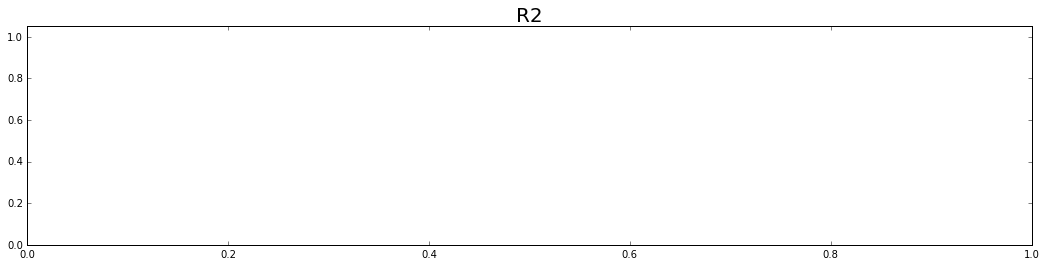

In [15]:
Rsquars = plt.figure(figsize = (18,18))

Colors = ['b','r','g','k','c','y']
Variables = ['R2','Slope','Intercept', 'YRange']
Position = 1
yMax = [1.05,2,1,0.5]
yMin = [0,0,-1,0]
for Variable in Variables:
    fig = Rsquars.add_subplot(4,1,Position)
    ColorPos = 0
    Line = 1
    plt.ylim(yMin[Position-1],yMax[Position-1])
    plt.title(Variable, fontsize=20)
    for Depth in Depths:
            plt.plot(CalibrationCoeffs.ix[Depth, Variable], c=Colors[ColorPos], linewidth = Line)
            ColorPos +=1
            Line += 1
    Position +=1

In [ ]:
Coeffs = pd.DataFrame(index = Depths)
for Depth in Depths:
    Coeffs.ix[Depth,'Slope'] = CalibrationCoeffs.ix[Depth,'Slope'].where(CalibrationCoeffs.ix[Depth,'Slope']>0).mean()
    Coeffs.ix[Depth,'Intercept'] = CalibrationCoeffs.ix[Depth,'Intercept'].where(CalibrationCoeffs.ix[Depth,'Slope']>0).mean()
    Coeffs.ix[Depth,'YRange'] = CalibrationCoeffs.ix[Depth,'YRange'].mean()

In [ ]:
Coeffs

In [ ]:
CalibrationCoeffs['AbsSlope'] = np.abs(CalibrationCoeffs.Slope)

In [ ]:
plt.scatter( CalibrationCoeffs.YRange, CalibrationCoeffs.Intercept)
plt.ylim(0,2)

#Look at underlying measurements from CS650

In [ ]:
AllPermData = pd.read_pickle('.\DataFrames\BarleyPerm_df')
AllPeriodData = pd.read_pickle('.\DataFrames\BarleyPeriod_df')
AllVRData = pd.read_pickle('.\DataFrames\BarleyVR_df')
AllTempData = pd.read_pickle('.\DataFrames\BarleyTemp_df')
AllECData = pd.read_pickle('.\DataFrames\BarleyEC_df')

AllPermData .columns = AllPermData.columns.droplevel(level = ['Sensor', 'MUX', 'Port','Units','Summary','Plot','Treatment','Rewet']) #drop index values that will get in the way
AllPeriodData.columns = AllPeriodData.columns.droplevel(level = ['Sensor', 'MUX', 'Port','Units','Summary','Plot','Treatment','Rewet']) #drop index values that will get in the way
AllVRData.columns = AllVRData.columns.droplevel(level = ['Sensor', 'MUX', 'Port','Units','Summary','Plot','Treatment','Rewet']) #drop index values that will get in the way
AllTempData.columns = AllTempData.columns.droplevel(level = ['Sensor', 'MUX', 'Port','Units','Summary','Plot','Treatment','Rewet']) #drop index values that will get in the way
AllECData.columns = AllECData.columns.droplevel(level = ['Sensor', 'MUX', 'Port','Units','Summary','Plot','Treatment','Rewet']) #drop index values that will get in the way

In [ ]:
PermMeans = AllPermData.ix['2014-11-05 08:00:00':'2015-02-11'].groupby(level=['Cultivar', 'Depth','Irrigation'],axis=1).mean()

Fig = plt.figure(figsize=(18, 60))

def MakePlot(Position, Depth, DepthLabel):
        Fig.add_subplot(8,1,Position, color_cycle=['b','r','g','b','r','g'])
        plt.title(DepthLabel + '  Permiattivity', fontsize=28);
        plt.plot(PermMeans.index,PermMeans.Dash.ix[:,Depth], '--');
        plt.plot(PermMeans.index,PermMeans.Omaka.ix[:,Depth], '-');
        plt.ylabel('-', fontsize=22);
        plt.tick_params(labelsize=16);
        plt.ylim(0,30);
        return;

MakePlot(1,'D1I','0-150 mm')
MakePlot(2,'D1B','0-150 mm')
MakePlot(3,'D2','150-300 mm')
MakePlot(4,'D3','300-600 mm')
MakePlot(5,'D4','600-900 mm')
MakePlot(6,'D5','900-1200 mm')
MakePlot(7,'D6','1200-1500 mm')
MakePlot(8,'D7','1500-1800 mm')

In [ ]:
TempMeans = AllTempData.ix['2014-11-05 08:00:00':'2015-02-11'].groupby(level=['Cultivar', 'Depth','Irrigation'],axis=1).mean()

Fig = plt.figure(figsize=(18, 60))

def MakePlot(Position, Depth, DepthLabel):
        Fig.add_subplot(8,1,Position, color_cycle=['b','r','g','b','r','g'])
        plt.title(DepthLabel + '  Temperature', fontsize=28);
        plt.plot(TempMeans.index,TempMeans.Dash.ix[:,Depth], '--');
        plt.plot(TempMeans.index,TempMeans.Omaka.ix[:,Depth], '-');
        plt.ylabel('-', fontsize=22);
        plt.tick_params(labelsize=16);
        plt.ylim(0,30);
        return;

MakePlot(1,'D1I','0-150 mm')
MakePlot(2,'D1B','0-150 mm')
MakePlot(3,'D2','150-300 mm')
MakePlot(4,'D3','300-600 mm')
MakePlot(5,'D4','600-900 mm')
MakePlot(6,'D5','900-1200 mm')
MakePlot(7,'D6','1200-1500 mm')
MakePlot(8,'D7','1500-1800 mm')

In [ ]:
PeriodMeans = AllPeriodData.ix['2014-11-05 08:00:00':'2015-02-11'].groupby(level=['Cultivar', 'Depth','Irrigation'],axis=1).mean()

Fig = plt.figure(figsize=(18, 60))

def MakePlot(Position, Depth, DepthLabel):
        Fig.add_subplot(8,1,Position, color_cycle=['b','r','g','b','r','g'])
        plt.title(DepthLabel + '  Period', fontsize=28);
        plt.plot(PeriodMeans.index,PeriodMeans.Dash.ix[:,Depth], '--');
        plt.plot(PeriodMeans.index,PeriodMeans.Omaka.ix[:,Depth], '-');
        plt.ylabel('mSec', fontsize=22);
        plt.tick_params(labelsize=16);
        plt.ylim(0,5);
        return;

MakePlot(1,'D1I','0-150 mm')
MakePlot(2,'D1B','0-150 mm')
MakePlot(3,'D2','150-300 mm')
MakePlot(4,'D3','300-600 mm')
MakePlot(5,'D4','600-900 mm')
MakePlot(6,'D5','900-1200 mm')
MakePlot(7,'D6','1200-1500 mm')
MakePlot(8,'D7','1500-1800 mm')

In [ ]:
VRMeans = AllVRData.ix['2014-11-05 08:00:00':'2015-02-11'].groupby(level=['Cultivar', 'Depth','Irrigation'],axis=1).mean()

Fig = plt.figure(figsize=(18, 60))

def MakePlot(Position, Depth, DepthLabel):
        Fig.add_subplot(8,1,Position, color_cycle=['b','r','g','b','r','g'])
        plt.title(DepthLabel + '  Voltage Ratio', fontsize=28);
        plt.plot(VRMeans.index,VRMeans.Dash.ix[:,Depth], '--');
        plt.plot(VRMeans.index,VRMeans.Omaka.ix[:,Depth], '-');
        plt.ylabel('mm/mm', fontsize=22);
        plt.tick_params(labelsize=16);
        plt.ylim(1,1.8);
        return;

MakePlot(1,'D1I','0-150 mm')
MakePlot(2,'D1B','0-150 mm')
MakePlot(3,'D2','150-300 mm')
MakePlot(4,'D3','300-600 mm')
MakePlot(5,'D4','600-900 mm')
MakePlot(6,'D5','900-1200 mm')
MakePlot(7,'D6','1200-1500 mm')
MakePlot(8,'D7','1500-1800 mm')

In [ ]:
ECMeans = AllECData.ix['2014-11-05 08:00:00':'2015-02-11'].groupby(level=['Cultivar', 'Depth','Irrigation'],axis=1).mean()

Fig = plt.figure(figsize=(18, 60))

def MakePlot(Position, Depth, DepthLabel):
        Fig.add_subplot(8,1,Position, color_cycle=['b','r','g','b','r','g'])
        plt.title(DepthLabel + '  Electrical Conductivity', fontsize=28);
        plt.plot(ECMeans.index,ECMeans.Dash.ix[:,Depth], '--');
        plt.plot(ECMeans.index,ECMeans.Omaka.ix[:,Depth], '-');
        plt.ylabel('mm/mm', fontsize=22);
        plt.tick_params(labelsize=16);
        #plt.ylim(1,1.8);
        return;

MakePlot(1,'D1I','0-150 mm')
MakePlot(2,'D1B','0-150 mm')
MakePlot(3,'D2','150-300 mm')
MakePlot(4,'D3','300-600 mm')
MakePlot(5,'D4','600-900 mm')
MakePlot(6,'D5','900-1200 mm')
MakePlot(7,'D6','1200-1500 mm')
MakePlot(8,'D7','1500-1800 mm')

In [ ]:
#TDRAgregated.to_excel('.\DataFrames\TDRCalibrationData.xls')
#NPDataVWC = NPData.divide(100)
#NPDataVWC.to_excel('.\DataFrames\NeutronProbeCalibrationData.xls')

##See if any other variables explain slope problems

In [ ]:
#Calculate D1 values
D1ECData = ((AllECData['D1B'].values + AllECData['D1I'].values)/2 + AllECData['D2'].values)/2
D1PermData = ((AllPermData['D1B'].values + AllPermData['D1I'].values)/2 + AllPermData['D2'].values)/2
D1PeriodData= ((AllPeriodData['D1B'].values + AllPeriodData['D1I'].values)/2 + AllPeriodData['D2'].values)/2
D1VRData= ((AllVRData['D1B'].values + AllVRData['D1I'].values)/2 + AllVRData['D2'].values)/2
D1TempData= ((AllTempData['D1B'].values + AllTempData['D1I'].values)/2 + AllTempData['D2'].values)/2
#Get D1 data into a data frame
Blocks = ['1','2','3','4']
levels = ['D1', Cultivars ,Irrigations ,Blocks]
DataIndex = pd.MultiIndex.from_product(levels, names=['Depth', 'Cultivar', 'Irrigation', 'Block'])
D1EC = pd.DataFrame(index = AllECData.index, columns = DataIndex, data = D1ECData)
D1Perm = pd.DataFrame(index = AllPermData.index, columns = DataIndex, data = D1PermData)
D1Period = pd.DataFrame(index = AllPeriodData.index, columns = DataIndex, data = D1PeriodData)
D1VR = pd.DataFrame(index = AllVRData.index, columns = DataIndex, data = D1VRData)
D1Temp = pd.DataFrame(index = AllTempData.index, columns = DataIndex, data = D1TempData)
#Join D1 data with other EC data
ECDataAgregated = pd.concat([AllECData,D1EC],axis = 1)
PermDataAgregated = pd.concat([AllPermData,D1Perm],axis = 1)
PeriodDataAgregated = pd.concat([AllPeriodData,D1Period],axis = 1)
VRDataAgregated = pd.concat([AllVRData,D1VR],axis = 1)
TempDataAgregated = pd.concat([AllTempData,D1Temp],axis = 1)

In [ ]:
for Depth in Depths:
    for Cultivar in Cultivars:
        for Irrigation in Irrigations:
            for Block in Blocks:
                Rep = int(Block)-1
                CalibrationCoeffs.ix[(Depth,Cultivar,Irrigation,Rep),'MeanEC'] = ECDataAgregated.ix[:,(Depth,Cultivar,Irrigation,Block)].mean()
                CalibrationCoeffs.ix[(Depth,Cultivar,Irrigation,Rep),'MeanVWC'] = TDRAgregated.ix[:,(Depth,Cultivar,Irrigation)].iloc[:,Rep].mean()
                CalibrationCoeffs.ix[(Depth,Cultivar,Irrigation,Rep),'MeanPerm'] = PermDataAgregated.ix[:,(Depth,Cultivar,Irrigation)].iloc[:,Rep].mean()
                CalibrationCoeffs.ix[(Depth,Cultivar,Irrigation,Rep),'MeanPeriod'] = PeriodDataAgregated.ix[:,(Depth,Cultivar,Irrigation)].iloc[:,Rep].mean()
                CalibrationCoeffs.ix[(Depth,Cultivar,Irrigation,Rep),'MeanVR'] = VRDataAgregated.ix[:,(Depth,Cultivar,Irrigation)].iloc[:,Rep].mean()
                CalibrationCoeffs.ix[(Depth,Cultivar,Irrigation,Rep),'MeanTemp'] = TempDataAgregated.ix[:,(Depth,Cultivar,Irrigation)].iloc[:,Rep].mean()

In [ ]:
Variables = ['VWC','EC','Perm','Period','VR','Temp']
Relations = plt.figure(figsize = (18,40)) 

Position = 1
for Var in Variables:
    fig = Relations.add_subplot(6,2,Position)
    plt.title(Var, fontsize = 20)
    XD6 = getattr(CalibrationCoeffs.ix['D6'],'Mean'+Var)
    XD7 = getattr(CalibrationCoeffs.ix['D7'],'Mean'+Var)
    plt.plot(XD6,CalibrationCoeffs.ix['D6'].MeanVWC, marker = 'o', markersize=20, linewidth = 0)
    plt.plot(XD7,CalibrationCoeffs.ix['D7'].MeanVWC, marker = 'o', markersize=20, c='r', linewidth = 0)
    Position +=1


In [ ]:
CalibrationCoeffs['ECNorm'] = CalibrationCoeffs['MeanEC']/CalibrationCoeffs['MeanVWC']
CalibrationCoeffs['VRNorm'] = CalibrationCoeffs['MeanVR']/CalibrationCoeffs['MeanVWC']

In [ ]:
Fig = plt.figure(figsize = (10,10)) 
plt.plot(CalibrationCoeffs.ix['D7'].ECNorm,CalibrationCoeffs.ix['D7'].AbsSlope, marker = 'o', markersize=20, linewidth = 0)
plt.plot(CalibrationCoeffs.ix['D6'].ECNorm,CalibrationCoeffs.ix['D6'].AbsSlope, marker = 'o', markersize=20, c='r', linewidth = 0)
#plt.xlim(0,0.22)
#plt.ylim(0,0.45)
plt.ylabel('AbsSlope')
plt.xlabel('ECNorm')

In [ ]:
Fig = plt.figure(figsize = (10,10)) 
plt.plot(CalibrationCoeffs.ix['D7'].VRNorm,CalibrationCoeffs.ix['D7'].AbsSlope, marker = 'o', markersize=20, linewidth = 0)
plt.plot(CalibrationCoeffs.ix['D6'].VRNorm,CalibrationCoeffs.ix['D6'].AbsSlope, marker = 'o', markersize=20, c='r', linewidth = 0)
#plt.xlim(0,0.22)
#plt.ylim(0,0.45)
plt.ylabel('AbsSlope')
plt.xlabel('VRNorm')

In [ ]:
Fig = plt.figure(figsize = (10,10)) 
plt.plot(CalibrationCoeffs.ix['D7'].MeanTemp,CalibrationCoeffs.ix['D7'].AbsSlope, marker = 'o', markersize=20, linewidth = 0)
plt.plot(CalibrationCoeffs.ix['D6'].MeanTemp,CalibrationCoeffs.ix['D6'].AbsSlope, marker = 'o', markersize=20, c='r', linewidth = 0)
#plt.xlim(0,0.22)
#plt.ylim(0,0.45)
plt.ylabel('AbsSlope')
plt.xlabel('MeanTemp')

In [ ]:
CorrectedTDR = pd.DataFrame(index = TDRAgregated.index,columns = TDRAgregated.columns)
Blocks = ['1','2','3','4']
for Depth in Depths:
    for Cultivar in Cultivars:
        for Irrigation in Irrigations:
            for Block in Blocks:
                a = Coeffs.ix[Depth,'Slope']
                b = Coeffs.ix[Depth, 'Intercept']
                CorrectedTDR[(Depth,Cultivar,Irrigation,Block)] = TDRAgregated.ix[:,(Depth,Cultivar,Irrigation,Block)] * a + b


In [ ]:
CorrectedTDR['D6','Omaka','High']#.iloc[:,Rep]

In [ ]:
Depths = ['D1', 'D3', 'D4', 'D5', 'D6', 'D7']
Cultivars =['Dash', 'Omaka']
Irrigations = ['Low', 'Mid', 'High']
Reps = [0,1,2,3]

Calibrations = plt.figure(figsize = (18,160))

Colors = ['b','r','g','y']

Position = 1
for Depth in Depths:
    for Cultivar in Cultivars:
        for Irrigation in Irrigations:
            #Make graph for each treatment x Depth combination
            fig = Calibrations.add_subplot(42,3,Position)
            ColorPos = 0
            fig.text(0.05,0.43,Depth + ' ' +Cultivar + ' ' +Irrigation, fontsize = 20)
            plt.ylim(0,0.5)
            plt.xlim(0,0.5)
            for Rep in Reps:
                #Plot data for each rep
                plt.scatter(CorrectedTDR[Depth,Cultivar,Irrigation].iloc[:,Rep],
                         NPData[Depth,Cultivar,Irrigation].iloc[:,Rep], 
                         c=Colors[ColorPos], s=100, label='Dash High', marker='o')
                ColorPos += 1
                
            plt.plot([0,0.5],[0,0.5], color = 'k' )
            Position += 1